In [44]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.optimize as opt
import errors as err
from sklearn.preprocessing import MinMaxScaler
import cluster_tools as ct
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
pd.options.mode.chained_assignment = None

In [45]:
def k_m_formatter(x, pos):
    """Convert numbers to 'K' for thousands or 'M' for millions."""
    if x >= 1_000_000:
        return f'{x / 1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x / 1_000:.1f}K'
    else:
        return int(x)

In [46]:
def plot_annotated_bar(df, x_col, y_col, title='', xlabel='', ylabel='', palette='viridis'):
    """
    Plots a bar graph with annotations using seaborn and matplotlib.
    
    Args:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    x_col (str): Name of the column to use as x-axis.
    y_col (str): Name of the column to use as y-axis.
    title (str, optional): Title of the plot.
    xlabel (str, optional): Label for the X-axis.
    ylabel (str, optional): Label for the Y-axis.
    palette (str, optional): Color palette for the bars.
    """
    # Create the plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    barplot = sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

    barplot.yaxis.set_major_formatter(ticker.FuncFormatter(k_m_formatter))

    # Add labels to the bars
    for p in barplot.patches:
        barplot.annotate(k_m_formatter(p.get_height(), None),  # Using thousands separator
                         (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                         ha='center', va='center',  # Center alignment
                         xytext=(0, 10),  # Position text 10 points above the bar
                         textcoords='offset points')  # Use offset points for positioning

    # Set labels and title
    plt.xlabel(xlabel)  # X-axis label
    plt.ylabel(ylabel)  # Y-axis label
    plt.title(title)  # Title of the plot
    plt.savefig('Bar.png', dpi=300)
    # Show the plot
    plt.show()

In [47]:
def plot_correlation_matrix(df, title='Correlation Matrix', cmap='coolwarm', show_values=True, figsize=(10, 8)):
    """
    Plots the correlation matrix for the given DataFrame without using a mask.

    Args:
    df (pandas.DataFrame): The DataFrame whose correlation matrix will be plotted.
    title (str, optional): Title of the plot.
    cmap (str, optional): Colormap of the correlation matrix.
    show_values (bool, optional): Whether to show the correlation coefficients in the plot.
    figsize (tuple, optional): Figure size given as (width, height).
    """
    # Calculate the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    sns.set(style='white')  # white background style for seaborn plots

    # Draw the heatmap
    heatmap = sns.heatmap(corr, annot=show_values, fmt=".2f", cmap=cmap,
                          cbar_kws={'shrink': .5}, linewidths=.5, square=True)

    # Configure the tick labels for better readability
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

    # Set plot title
    plt.title(title)
    plt.savefig('correlation matrix.png', dpi=300)
    # Show the plot
    plt.show()

In [48]:
def plot_scatter(df, x_col, y_col, with_regression=False, title='', xlabel='', ylabel='', color='blue', marker='o', figsize=(8, 6)):
    """
    Plots a scatter plot of two variables from a DataFrame, with an optional regression line.

    Args:
    df (pandas.DataFrame): The DataFrame containing the data.
    x_col (str): Column name to be used for the x-axis.
    y_col (str): Column name to be used for the y-axis.
    with_regression (bool, optional): If True, include a regression line in the plot.
    title (str, optional): Title of the plot.
    xlabel (str, optional): Label for the x-axis.
    ylabel (str, optional): Label for the y-axis.
    color (str, optional): Color of the plot points.
    marker (str, optional): Marker style of the plot points.
    figsize (tuple, optional): Figure size, given as (width, height).
    """
    # Setup the plot
    plt.figure(figsize=figsize)
    sns.set(style='whitegrid')  # Setting the style of the plot

    # Scatter plot with or without regression line
    if with_regression:
        sns.regplot(x=x_col, y=y_col, data=df, scatter_kws={'color': color, 'marker': marker})
    else:
        plt.scatter(df[x_col], df[y_col], color=color, marker=marker)

    # Set plot labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig('scatter plot.png', dpi=300)
    # Show the plot
    plt.show()

In [49]:
def plot_silhouette_score(data, max_clusters=10):
    """
    Evaluate and plot silhouette scores for different numbers of clusters.

    Parameters:
    - data: The input data for clustering.
    - max_clusters: The maximum number of clusters to evaluate.

    Returns:
    """

    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform clustering using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.savefig('silhouette_score.png', dpi=300)
    plt.show()

In [50]:
def get_data_for_bar(cols, ind, dataframes, year):
    """
    Retrieves and transforms data for a specific year from a list of dataframes for bar chart visualization.

    This function selects a dataframe from a list by index, then filters for specific columns and the given year.
    It transposes the dataframe to switch rows and columns, sets the year as the column header, and ensures
    the data is of float type, making it suitable for plotting a bar chart.

    Parameters:
    - cols (list of str): Column names to be retained for the bar chart.
    - ind (int): Index of the dataframe in the list to be processed.
    - dataframes (list of pandas.DataFrame): List containing the dataframes to be processed.
    - year (str): The year for which the data is to be retrieved.

    Returns:
    - pandas.DataFrame: A transposed DataFrame with the selected year's data ready for bar chart plotting.
    """
    df = dataframes[ind]
    df = df[cols]
    df = df[df['Year'] == year]
    df_t = df.T
    df_t.columns = df.Year
    df_t = df_t.astype(float)
    return df_t


In [51]:
def get_data_for_heat_map(Indicators, data_frames, country):
    """
    Prepares a DataFrame for a heatmap by processing a list of data frames corresponding to various indicators.
    
    This function processes each data frame in the list 'data_frames', corresponding to the indicators provided
    in 'Indicators'. It extracts data for a specified country, handles missing values by imputing the mean of
    each column, and assembles this into a new DataFrame suitable for generating a heatmap.
    
    Parameters:
    - Indicators : list of str
        A list of strings that represents the names of the indicators. Each indicator name is expected to 
        have a format where it might contain additional details in parentheses that should be ignored (e.g., 
        'Population (Total)').
    - data_frames : list of pandas.DataFrame
        A list of DataFrame objects, each corresponding to an indicator in 'Indicators'. Each DataFrame is 
        expected to have columns named after countries.
    - country : str
        The name of the country for which data is to be extracted from each DataFrame.
    
    Returns:
    - df : pandas.DataFrame
        A DataFrame where each column represents an indicator (with parentheses removed from names), and 
        each row corresponds to an observation of these indicators for the specified country. Missing data 
        within each column is filled with the mean of that column.
    
    Example:
    Assuming 'data_frames' is a list of DataFrames where each contains data on various countries for specific 
    indicators and 'Indicators' is a list like ['Population (Total)', 'GDP (Current US$)'],
    calling `get_data_for_heat_map(['Population (Total)', 'GDP (Current US$)'], data_frames, 'USA')`
    would return a DataFrame with two columns ('Population', 'GDP') with the data filled where missing values 
    are replaced by the column means.
    
    Notes:
    - This function is particularly useful in preparing data for visualization, such as in heatmaps, where
      data uniformity and completeness are crucial.
    - The function assumes that the structure of each DataFrame in 'data_frames' is consistent and that 
      column names correctly correspond to the names of countries.
    """
    data_dic = {}
    for ind in range(len(Indicators)):
        data = data_frames[ind]
        data = data[country]
        column_means = data.mean()
        data = data.fillna(column_means)
        data_dic[Indicators[ind].split('(')[0]] = data.tolist()
    df = pd.DataFrame(data_dic)
        
    return df

In [52]:
def make_clusters(df, ind1, ind2, xlabel, ylabel, tit, n_clu_cen, df_fit, df_min, df_max, new_data, new_df):
    """
    Performs KMeans clustering on provided data, plots the clusters, and annotates cluster centers.

    This function fits a KMeans clustering model to the 'df_fit' dataset and uses this model to predict
    clusters for both original and new datasets. It generates a plot that shows the original data points,
    new data points, and cluster centers with annotations.

    Parameters:
    - df : pandas.DataFrame
        The original dataset containing the data points.
    - ind1, ind2 : str
        Column names in 'df' which are used for the x and y axes of the plot.
    - xlabel, ylabel : str
        Labels for the x and y axes of the plot.
    - tit : str
        Title of the plot.
    - n_clu_cen : int
        Number of cluster centers for KMeans clustering.
    - df_fit : pandas.DataFrame
        The dataset used to fit the KMeans model.
    - df_min, df_max : numpy.array
        Arrays containing the minimum and maximum values used for data scaling.
    - new_data : numpy.array
        New data points to be predicted by the KMeans model.
    - new_df : pandas.DataFrame
        DataFrame containing new data points for plotting.

    Returns:
    None. Generates and displays a scatter plot and saves it to a PNG file.

    Notes:
    - The 'ct.backscale' function is assumed to rescale the cluster centers back to their original scale.
    - The plot includes three scatter plots: one for original data, one for new data, and one for cluster centers.
    - Each cluster center is annotated with its respective group number directly in the plot.
    """
    nc = n_clu_cen  # number of cluster centers
    kmeans = KMeans(n_clusters=nc, n_init=10, random_state=0)
    kmeans.fit(df_fit)  # Fit model on initial data
    
    # Extract labels and cluster centers from the fitted model
    labels = kmeans.labels_
    cen = kmeans.cluster_centers_
    
    # Prepare plot
    plt.figure(figsize=(8, 8))
    
    # Scatter plot for original data
    original_scatter = plt.scatter(df[ind1], df[ind2], c=labels, cmap="tab10", label='Original Data')
    
    # Predict clusters for new data and plot
    new_labels = kmeans.predict(new_data)  # Predicting clusters for new data based on the fitted model
    new_data_scatter = plt.scatter(new_df[ind1], new_df[ind2], c=new_labels, cmap="tab10", marker="s", label='New Data')
    
    # Rescale and show cluster centers
    scen = ct.backscale(cen, df_min, df_max)  # Assuming 'ct.backscale' is a function you've defined elsewhere for rescaling
    xc = scen[:, 0]
    yc = scen[:, 1]
    centers_scatter = plt.scatter(xc, yc, c="k", marker="d", s=80, label='Cluster Centers')  # Black diamonds for cluster centers
    
    # Annotate cluster centers with their respective group numbers
    for i, (x, y) in enumerate(zip(xc, yc)):
        plt.annotate(f'Group {i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Add legend, labels, title, and save the plot
    plt.legend(handles=[original_scatter, new_data_scatter, centers_scatter], title="Clusters")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(tit)
    plt.savefig('Clustering_plot.png', dpi=300)
    plt.show()

In [53]:
def logistics(t, a, k, t0):
    """ Computes logistics function with scale and incr as free parameters
    """
    f = a / (1.0 + np.exp(-k * (t - t0)))
    return f

In [54]:
def fit_and_predict(df, Country_name, Ind, tit, tit_fore, initial):
    """
    Fit a logistic model to the data for a specified country and predict future values.
    
    Parameters:
    - df : pandas.DataFrame
        Data containing the population (or other indicator) indexed by year.
    - Country_name : str
        The name of the country to analyze. This should be a column name in `df`.
    - Ind : str
        Indicator name to be used as the y-axis label.
    - tit : str
        Title for the initial fitting plot.
    - tit_fore : str
        Title for the forecast plot.
    - initial : list or tuple
        Initial guess for the parameters of the logistic model.
        
    Returns:
    None. The function generates two plots: one showing the fit of the model to the existing data
    and another showing the forecast along with confidence intervals.
    
    Outputs:
    - Two PNG files are saved:
        1. `{Country_name}b.png` - Plot showing the data and the logistic fit.
        2. `{Country_name}b_forecast.png` - Plot showing both historical data and forecast with error bounds.
    
    Notes:
    - The logistic model function `logistics` must be defined elsewhere in the code.
    - The `error_propagation` module is assumed to be available as `err` for calculating error bounds.
    """
    # Fit the model
    popt, pcorr = opt.curve_fit(logistics, df.index, df[Country_name], p0=initial)
    df["pop_log"] = logistics(df.index, *popt)
    
    # Plot the fitted data
    plt.figure()
    plt.plot(df.index, df[Country_name], label="data")
    plt.plot(df.index, df["pop_log"], label="fit")
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel(Ind)
    plt.title(tit)
    plt.savefig(Country_name + 'b.png', dpi=300)
    
    # Prepare for forecast plotting
    years = np.linspace(df.index.min(), 2030)
    print(*popt)
    popt, pcorr = opt.curve_fit(logistics, df.index, df[Country_name], p0=initial)
    pop_log = logistics(years, *popt)
    sigma = err.error_prop(years, logistics, popt, pcorr)
    low = pop_log - sigma
    up = pop_log + sigma
    
    # Plot the forecast with error ranges
    plt.figure()
    plt.title(tit_fore)
    plt.plot(df.index, df[Country_name], label="data")
    plt.plot(years, pop_log, label="Forecast")
    plt.fill_between(years, low, up, alpha=0.5, color="y")
    plt.legend(loc="upper left")
    plt.xlabel('Years')
    plt.ylabel(Ind)
    plt.savefig(Country_name + 'b_forecast.png', dpi=300)
    plt.show()

In [55]:
def get_data_to_fit(df, country_name, start_year, end_year):
    """
    Filters and prepares data for model fitting within a specified year range for a given country.

    This function selects data for a specified country and time frame from a DataFrame. It converts
    the 'Year' column to integers, filters rows based on the given start and end years, replaces
    missing values with zero, and sets the 'Year' column as the index.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - country_name (str): The name of the country for which the data is filtered.
    - start_year (int): The starting year for the data selection.
    - end_year (int): The ending year for the data selection.

    Returns:
    - pandas.DataFrame: A DataFrame indexed by 'Year' and containing data for the specified country and time frame.
    """
    df = df[['Year', country_name]]
    df['Year'] = df['Year'].astype(int)
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    df = df.fillna(0)
    df = df.set_index('Year')
    return df

In [56]:
def refine_data(df, Indicators):
    """
    Processes and refines data for given indicators from a DataFrame structured with an 'Indicator Name' column.

    This function filters the input DataFrame for each indicator specified, transposes the data, and then
    restructures it by setting the appropriate headers and managing types. It is specifically tailored to
    work with data where each row represents an indicator and includes a country name followed by yearly data.

    Parameters:
    - df : pandas.DataFrame
        The input DataFrame containing the data to be refined. It is expected that the DataFrame has a column
        titled 'Indicator Name' and rows containing indicator data along with a 'Country Name' which needs
        to be handled separately.
    - Indicators : list of str
        A list of strings that specifies which indicators to filter from the DataFrame. These should match
        the entries in the 'Indicator Name' column of the DataFrame.

    Returns:
    - dataframes : list of pandas.DataFrame
        A list containing one DataFrame for each indicator specified. Each DataFrame will be transposed such
        that years become rows and indicator values become columns, and the DataFrame will only include data
        relevant to that specific indicator.

    Example:
    Assuming a DataFrame `df` structured with 'Country Name', 'Indicator Name', and years as columns, where
    each row after the first specifies an indicator's yearly data for a country:

        | Country Name | Indicator Name | 2000 | 2001 | ... | 2020 |
        |--------------|----------------|------|------|-----|------|
        | Country A    | GDP            | 100  | 105  | ... | 150  |
        | Country A    | Population     | 50   | 51   | ... | 55   |

    Calling `refine_data(df, ['GDP', 'Population'])` would process this DataFrame to produce a list of two
    DataFrames, one for GDP and one for Population, each formatted with years as rows and values as columns.

    Notes:
    - It is assumed that 'Country Name' is the first row index after transposing. Adjustments might be needed
      if the structure of the input DataFrame differs.
    - This function is tailored to data sets where rows include a 'Country Name' and columns from specific years.
    - The function returns floating point numbers and resets the index for usability in further processing.
    """
    dataframes = []
    for ind in Indicators:
        data = df[df['Indicator Name'] == ind]
        data = data.drop('Indicator Name', axis=1)
        data = data.T
        data.columns = data.iloc[0]
        data = data.drop(['Country Name'])
        data = data.astype(float)
        data['Year'] = data.index
        data = data.reset_index()
        data = data.drop('index', axis=1)
        dataframes.append(data)
        
    return dataframes


In [57]:
Indicators = ["Agricultural land (sq. km)","Population, total","Forest area (sq. km)","CO2 emissions (kt)","Renewable energy consumption (% of total final energy consumption)","Arable land (% of land area)","Urban population"]
world_bank_data = pd.read_csv('World_Climate data.csv',skiprows=4)
world_bank_data = world_bank_data[world_bank_data['Indicator Name'].isin(Indicators)]
world_bank_data = world_bank_data.drop(['Country Code','Indicator Code','Unnamed: 67'], axis=1)
data_frames = refine_data(world_bank_data, Indicators)

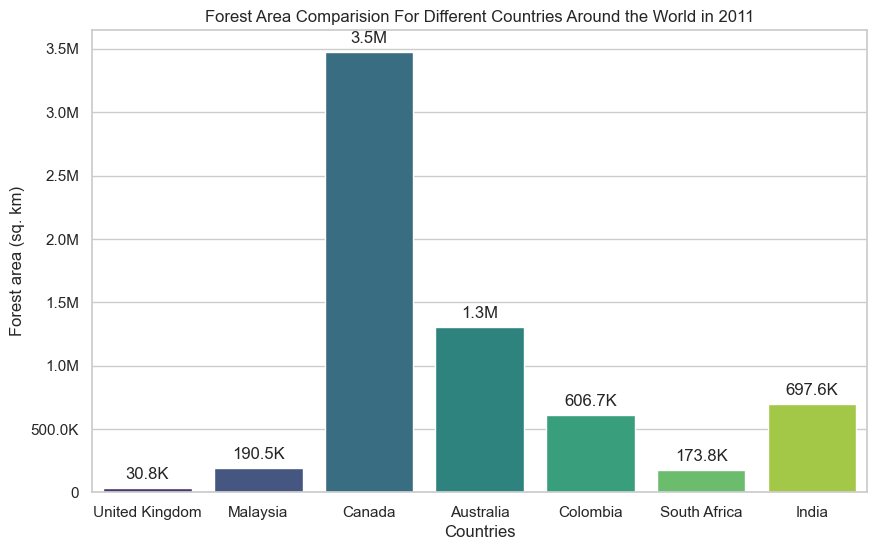

In [58]:
cols = ['United Kingdom','Malaysia','Canada','Australia','Colombia','South Africa','India', 'Year']
bar_data_2011 = get_data_for_bar(cols,2,data_frames,'2011')
bar_data_2021 = get_data_for_bar(cols,2,data_frames,'2021')
plot_annotated_bar(bar_data_2011.iloc[:-1],bar_data_2011.index[:-1], '2011','Forest Area Comparision For Different Countries Around the World in 2011','Countries','Forest area (sq. km)')

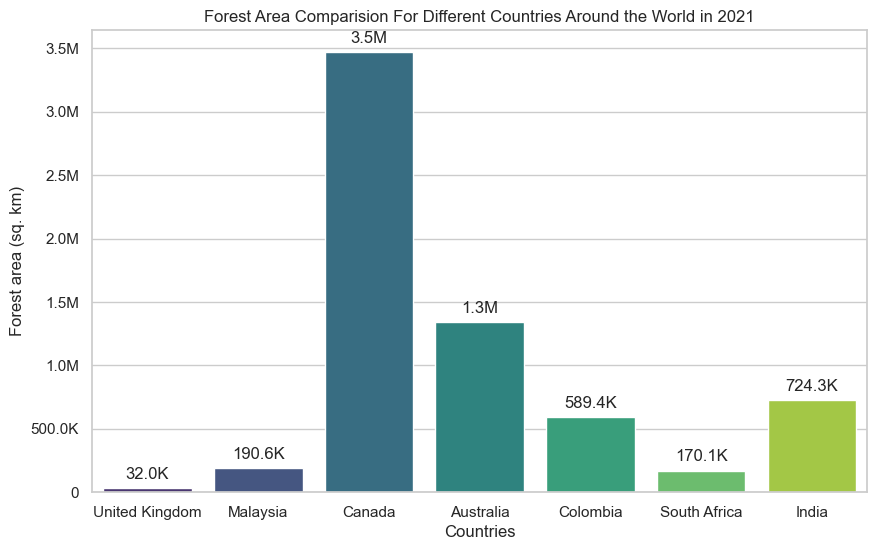

In [59]:
plot_annotated_bar(bar_data_2021.iloc[:-1],bar_data_2021.index[:-1], '2021','Forest Area Comparision For Different Countries Around the World in 2021','Countries','Forest area (sq. km)')

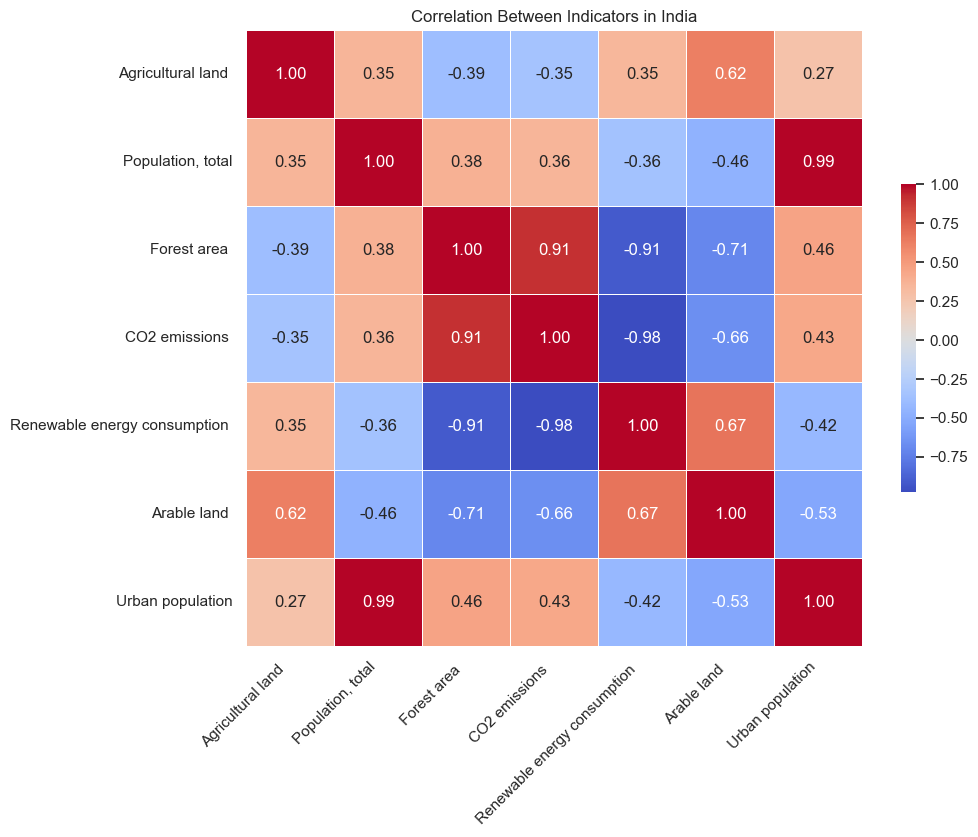

In [60]:
df = get_data_for_heat_map(Indicators, data_frames, 'India')
df.head()
plot_correlation_matrix(df,'Correlation Between Indicators in India' )

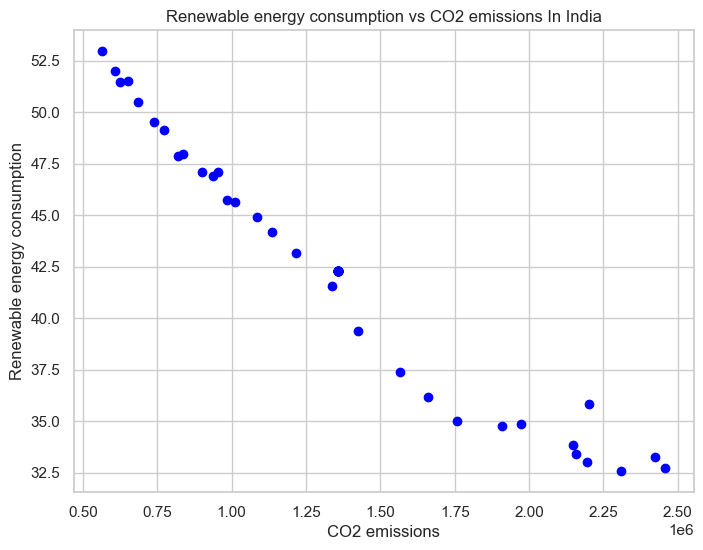

In [61]:
plot_scatter(df,'CO2 emissions ' ,'Renewable energy consumption ',  False, 'Renewable energy consumption vs CO2 emissions In India','CO2 emissions','Renewable energy consumption' )

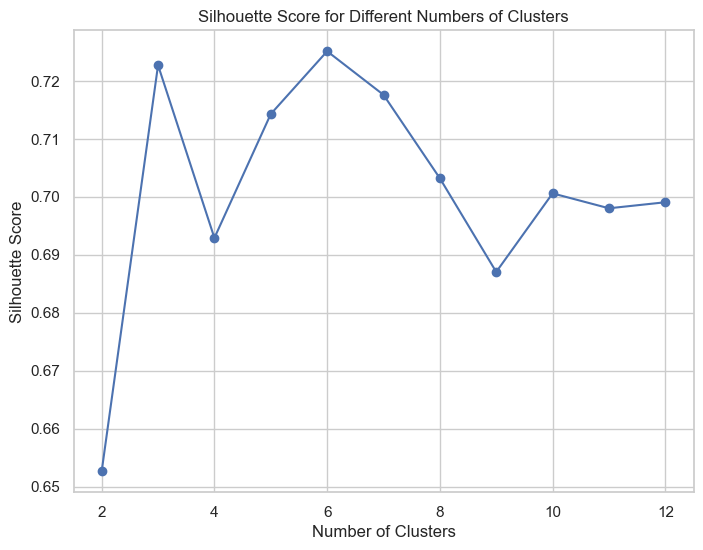

In [62]:
df_ = df[['CO2 emissions ', 'Forest area ']]
train_df = df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_df = df.drop(train_df.index)
df_fit, df_min, df_max = ct.scaler(df_)
train_df_fit = df_fit.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_df_fit = df_fit.drop(train_df.index)

plot_silhouette_score(df_fit,12)

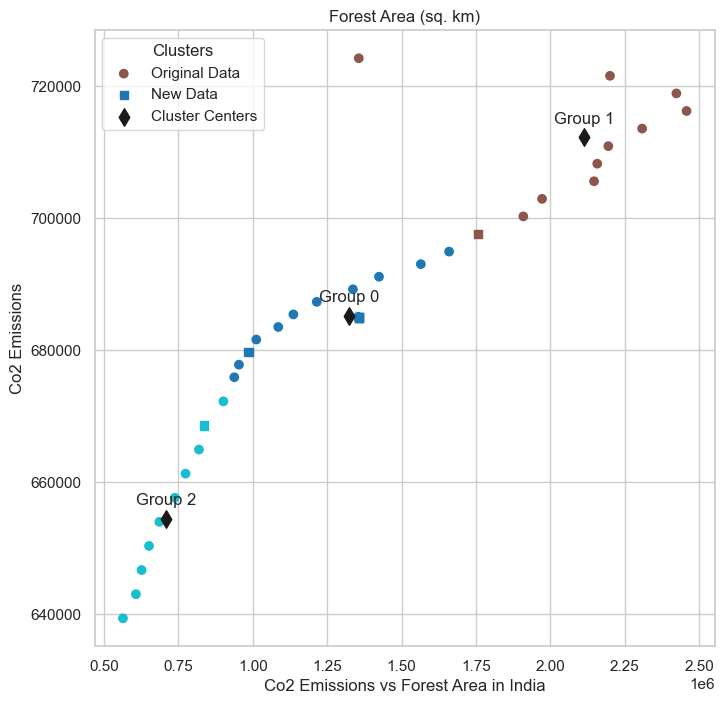

In [63]:
make_clusters(train_df,'CO2 emissions ', 'Forest area ','Co2 Emissions vs Forest Area in India','Co2 Emissions','Forest Area (sq. km)',3, train_df_fit, df_min, df_max, test_df_fit,test_df)

10389580.83259032 0.06276447453095466 2036.8238414774328


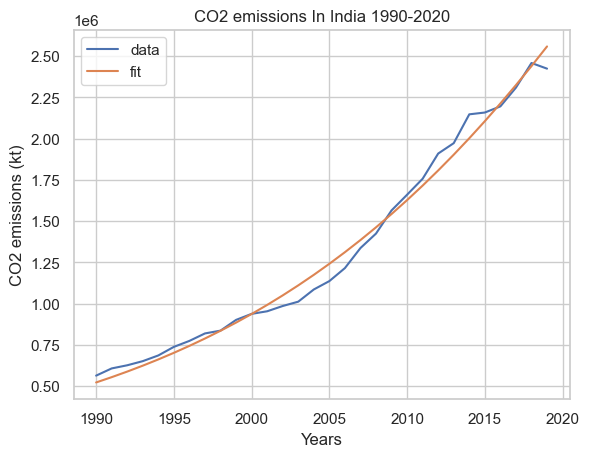

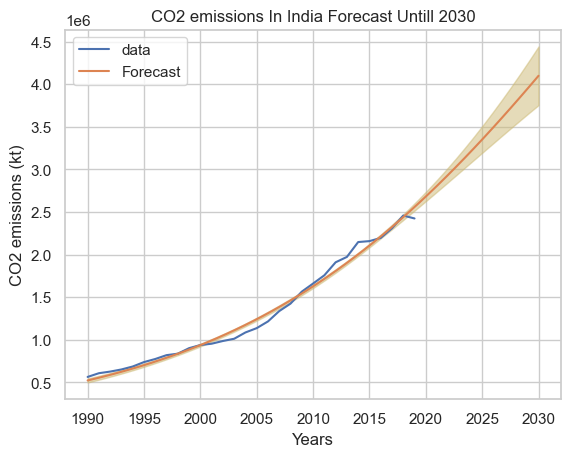

In [64]:



fit_and_predict(get_data_to_fit(data_frames[3],'India',1990,2019),'India','CO2 emissions (kt)',"CO2 emissions In India 1990-2020","CO2 emissions In India Forecast Untill 2030",(10e6, 0.5, 1990.0))


778790.3069343301 0.030883723328687638 1940.2544541483746


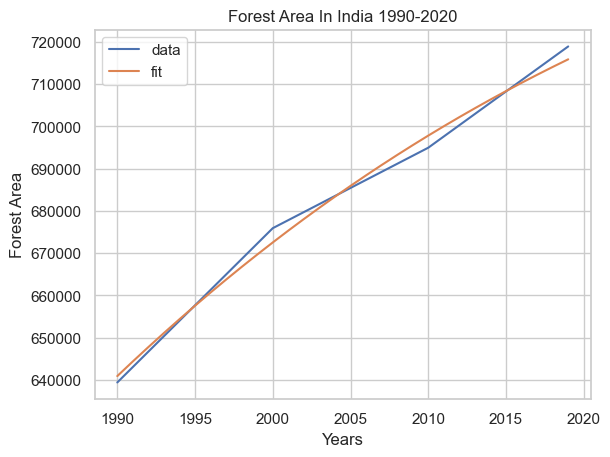

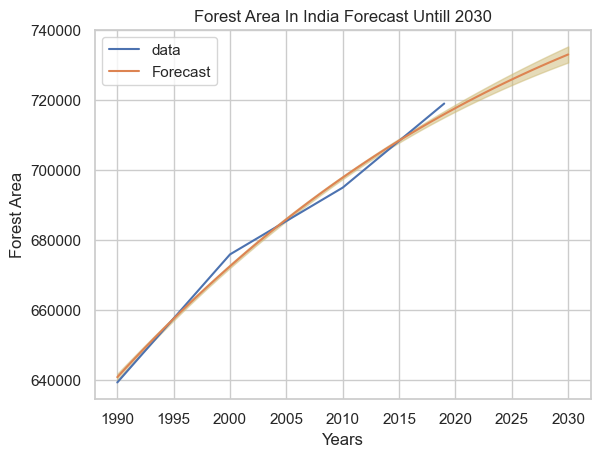

In [65]:
fit_and_predict(get_data_to_fit(data_frames[2],'India',1990,2019),'India','Forest Area',"Forest Area In India 1990-2020","Forest Area In India Forecast Untill 2030",(10e6, 0.2, 1990.0))